In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import laplace, divergence
from scipy.stats.qmc import Sobol
from pinns.model import mlp
from pinns.opt import train_nn
from pinns.integrate import integrate, midpoint, gauss2
from pinns.interpolate import shape_function
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [3]:
a = 1.
b = 1.
c = 1.
domain = Hypercube((-a / 2, -b / 2, -c / 2), (a / 2, b / 2, c / 2))
x_dom = array(Sobol(3, seed=0).random_base2(13))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(10))
x_bnd = domain.transform_bnd(x_bnd)


In [4]:
# TODO:
# find constants A, K1, Ms
# train init mag  # ok
# stray field solver  # ok
# compute Ha, Hex
# minimize energy

In [5]:
_x_bnd = array(Sobol(2, seed=1).random_base2(8))
_x_bnd = domain.transform_bnd(_x_bnd)
x1 = [_x_bnd[_x_bnd[:, i] == -0.5, :] for i in range(3)]
x2 = [_x_bnd[_x_bnd[:, i] == 0.5, :] for i in range(3)]
l = shape_function(x1, x2)

In [6]:
weights = array(Sobol(4, seed=12345).random_base2(8))
W_elm = (weights[:, :3] * 2 - 1) * 4
b_elm = (weights[:, 3] * 2 - 1) * 4


def unit_vec(x):
    return x / norm(x, axis=-1, keepdims=True)

# def m_init_vortex(x):
#     x, y, z = x[..., 0], x[..., 1], x[..., 2]
#     rc = 0.14
#     r = sqrt(x ** 2 + y ** 2)
#     k = r**2 / rc**2

#     mx = exp(-2*k)
#     my = - z / r * sqrt(1 - exp(-4*k))
#     mz = y / r * sqrt(1 - exp(-4*k))
    
#     mag = stack([mx, my, mz], axis=-1)
#     return unit_vec(mag)


# def m_init_flower(x):
#     # return array([0., 0., 1.])
#     mx = 1 / a * x[..., 0] * x[..., 2]
#     my = 1 / c * x[..., 1] * x[..., 2] + 1 / b ** 3 * x[..., 1] ** 3 * x[..., 2] ** 3
#     mz = ones_like(my)
#     mag = stack([mx, my, mz], axis=-1)
#     return unit_vec(mag)



In [7]:
# import discretisedfield as df
# import micromagneticmodel as mm
# import oommfc as oc

# def unit_vec_np(x):
#     return x / np.linalg.norm(x, axis=-1, keepdims=True)

# def m_init_vortex(x):
#     x = np.array(x) / 100e-9  - 0.5
#     x, y, z = x[..., 0], x[..., 1], x[..., 2]
#     rc = 0.14
#     r = np.sqrt(z ** 2 + x ** 2)
#     k = r**2 / rc**2

#     my = np.exp(-2*k)
#     mx = - z / r * np.sqrt(1 - np.exp(-4*k))
#     mz = x / r * np.sqrt(1 - np.exp(-4*k))
    
#     mag = np.stack([mx, my, mz], axis=-1)
#     return unit_vec_np(mag)


# def m_init_flower(x):
#     x = (np.array(x) / 100e-9 * 2 - 1)
#     x, y, z = x[..., 0], x[..., 1], x[..., 2]
    
#     k = 0.1
#     mx = k / a * x * z
#     my = k / c * y * z# + 1 / b ** 3 * y ** 3 * z ** 3
#     mz = np.ones_like(my)
#     mag = np.stack([mx, my, mz], axis=-1)
#     return unit_vec_np(mag)
#     #return mag[..., 0], mag[..., 1], mag[..., 2]

# # Function for initiaising the flower state.
# # def m_init_flower(pos):
# #     x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
# #     mx = 0
# #     my = 2*z - 1
# #     mz = 2*y + 1
# #     norm_squared = mx**2 + my**2 + mz**2
# #     if norm_squared <= 0.05:
# #         return (1, 0, 0)
# #     else:
# #         return (mx, my, mz)

# # # Function for initialising the vortex state.
# # def m_init_vortex(pos):
# #     x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
# #     mx = 0
# #     my = np.sin(np.pi/2 * (x-0.5))
# #     mz = np.cos(np.pi/2 * (x-0.5))

# #     return (mx, my, mz)



# def minimise_system_energy(L, m_init):
#     print("L={:7}, {} ".format(L, m_init.__name__), end="")
#     N = 16  # discretisation in one dimension
#     cubesize = 100e-9  # cube edge length (m)
#     cellsize = cubesize/N  # discretisation in all three dimensions.
#     lex = cubesize/L  # exchange length.

#     Km = 1e6  # magnetostatic energy density (J/m**3)
#     Ms = np.sqrt(2*Km/mm.consts.mu0)  # magnetisation saturation (A/m)
#     A = 0.5 * mm.consts.mu0 * Ms**2 * lex**2  # exchange energy constant
#     K = 0.1*Km  # Uniaxial anisotropy constant
#     u = (0, 0, 1)  # Uniaxial anisotropy easy-axis

#     p1 = (0, 0, 0)  # Minimum sample coordinate.
#     p2 = (cubesize, cubesize, cubesize)  # Maximum sample coordinate.
#     cell = (cellsize, cellsize, cellsize)  # Discretisation.
#     mesh = df.Mesh(p1=(0, 0, 0), p2=(cubesize, cubesize, cubesize),
#                    cell=(cellsize, cellsize, cellsize))  # Create a mesh object.

#     system = mm.System(name='stdprob3')
#     system.energy = mm.Exchange(A=A) + mm.UniaxialAnisotropy(K=K, u=u) + mm.Demag()
#     x, y, z = np.meshgrid(*mesh.midpoints)

#     X = jnp.stack([x, y, z], axis=-1)
#     _X = X.reshape(-1, 3)
#     _X = np.array(_X)

#     #mag = np.apply_along_axis(m_init_flower, 1, _X).reshape(X.shape)
#     mag = m_init(_X).reshape(X.shape)

#     system.m = df.Field(mesh, dim=3, value=mag, norm=Ms)
#     #return system
#     md = oc.MinDriver(stopping_mxHxm=1e-8)
#     md.drive(system, overwrite=True)
#     # 
#     # evolver =  oc.RungeKuttaEvolver(method='rk4')
#     # md = oc.TimeDriver()
#     # md.drive(system, overwrite=True, t=2e-9, n=10000)

#     return system


# ax = plt.figure().add_subplot(projection='3d')

# system = minimise_system_energy(8.46, m_init_flower)
# # x, y, z = system.m.mesh.midpoints
# # X = jnp.stack([x, y, z], axis=-1)
# # _X = X.reshape(-1, 3)
# # _X = np.array(_X)


# mag = system.m.array
# x, y, z = jnp.meshgrid(jnp.linspace(0, 1, 16),
#                       jnp.linspace(0, 1, 16),
#                       jnp.linspace(0, 1, 16))
# ax.quiver(x, y, z, mag[..., 0], mag[..., 1], mag[..., 2], length=0.1, normalize=True)
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")

In [8]:
# def get_data(lam, init_state):
#     system = minimise_system_energy(lam, init_state)        
#     mag = system.m.array.reshape(-1, 3)
#     mag = unit_vec_np(mag)
    
#     X = stack(np.meshgrid(*system.m.mesh.midpoints), axis=-1) / 100e-9 - 0.5
#     X = X.reshape(-1, 3)
#     _L = np.ones((X.shape[0], 1)) * lam
#     X = np.append(X, _L, axis=-1)
#     return X, mag

# lam = np.linspace(8, 9, 20)
# data_flower = [get_data(l, m_init_flower) for l in lam]
# data_vortex = [get_data(l, m_init_vortex) for l in lam]


In [9]:
# X_flower = array(np.concatenate([x[0] for x in data_flower]))
# mag_flower = array(np.concatenate([x[1] for x in data_flower]))
# X_vortex = array(np.concatenate([x[0] for x in data_vortex]))
# mag_vortex = array(np.concatenate([x[1] for x in data_vortex]))

In [10]:
# # NBVAL_IGNORE_OUTPUT
# L_array = np.linspace(8, 9, 5)
# vortex_energies, flower_energies = [], []
# for L in L_array:
#     vortex = minimise_system_energy(L, m_init_vortex)
#     flower = minimise_system_energy(L, m_init_flower)
#     vortex_energies.append(vortex.table.data.tail(1)['E'][0])
#     flower_energies.append(flower.table.data.tail(1)['E'][0])

# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 4))
# plt.plot(L_array, vortex_energies, 'o-', label='vortex')
# plt.plot(L_array, flower_energies, 'o-', label='flower')
# plt.xlabel('L (lex)')
# plt.ylabel('E (J)')
# plt.grid()
# plt.legend();


In [11]:
# ax = plt.figure().add_subplot(projection='3d')

# system = minimise_system_energy(8.46, m_init_vortex)
# # x, y, z = system.m.mesh.midpoints
# # X = jnp.stack([x, y, z], axis=-1)
# # _X = X.reshape(-1, 3)
# # _X = np.array(_X)


# mag = system.m.array
# x, y, z = jnp.meshgrid(jnp.linspace(0, 1, 16),
#                       jnp.linspace(0, 1, 16),
#                       jnp.linspace(0, 1, 16))
# ax.quiver(x, y, z, mag[..., 0], mag[..., 1], mag[..., 2], length=0.1, normalize=True)
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")


In [12]:
# def cat2sph(x):
#     x = unit_vec(x)
#     phi = jnp.arctan2(x[..., 1], x[..., 0])
#     theta = jnp.arccos(x[..., 2])
#     return jnp.stack([phi, theta], axis=-1)

# def sph2cat(anlges):
#     phi = anlges[..., 0]
#     theta = anlges[..., 1]
#     x = cos(phi) * sin(theta)
#     y = sin(phi) * sin(theta)
#     z = cos(theta)
#     return jnp.stack([x, y, z], axis=-1)

# def cat2sph(x):
#     r = sqrt(x[..., 0] ** 2 + x[..., 1] ** 2)
#     theta = jnp.arctan2(r, x[..., 2])
#     phi = jnp.arctan2(x[..., 1], x[..., 0])
#     return jnp.stack([theta, phi], axis=-1)

# def sph2cat(theta):
#     phi = theta[..., 1]
#     theta = theta[..., 0]
#     x = cos(phi) * sin(theta)
#     y = sin(phi) * sin(theta)
#     z = cos(theta)
#     return jnp.stack([x, y, z], axis=-1)

In [13]:

from pinns.opt import train_nn

def m_init_vortex(x):
    #x = array(x) / 100e-9  - 0.5
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(z ** 2 + x ** 2)
    k = r**2 / rc**2

    my = exp(-2*k)
    mx = - z / r * sqrt(1 - exp(-4*k))
    mz = x / r * sqrt(1 - exp(-4*k))
    
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)


def m_init_flower(x):
    #return zeros_like(x).at[..., 2].set(1.)
    #x = (array(x) / 100e-9 * 2 - 1)
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    
    k = 1.
    mx = k / a * x * z
    my = k / c * y * z# + 1 / b ** 3 * y ** 3 * z ** 3
    mz = np.ones_like(my)
    mag = np.stack([mx, my, mz], axis=-1)
    return unit_vec(mag)


key, subkey = random.split(random.PRNGKey(42), 2)
mag_model, params = mlp(subkey, [4, 200, 200, 200, 200, 3])
tx = optax.adam(1e-5)
init_state = TrainState.create(
    apply_fn=mag_model.apply, 
    params=params,
    tx=tx
)

lam_dom = (8., 9.)

def draw_lam(key, n):
    return random.uniform(key, (n, )) * (lam_dom[1] - lam_dom[0]) + lam_dom[0]


def train_init_mag(theta_nn, state, init_mag, key, epochs=500, batch_size=100):
    mag = init_mag(x_dom)
    
    @jit
    def make_batches(rng):
        k1, k2 = random.split(rng)
        batches = x_dom.shape[0] // batch_size

        perms_dom = jax.random.permutation(k1, x_dom.shape[0])
        perms_dom = perms_dom[:batches * batch_size]  # skip incomplete batch
        perms_dom = perms_dom.reshape((batches, batch_size))
        # return X[perms_dom], m[perms_dom]
        lam = draw_lam(k2, batches)
        
        return x_dom[perms_dom], mag[perms_dom], lam
        
    
    @jit
    def loss(params, x, m, lam):
        lam = ones((x.shape[0])) * lam
        m_pred = theta_nn.apply(params, jnp.append(x, lam[:, None], axis=-1))
        l = mean(norm(m_pred - m, axis=-1) ** 2)
        return l, {'loss': l}


    return train_nn(loss, state, make_batches, key, epochs=epochs)

key, train_key = random.split(key)
init_state_flower, hist_flower_init = train_init_mag(
    mag_model, 
    init_state, 
    m_init_flower, 
    train_key, epochs=2000)
init_state_vortex, hist_vortex_init = train_init_mag(
    mag_model, 
    init_state, 
    m_init_vortex, 
    train_key, epochs=2000)


In [14]:
#init_state_flower, hist_flower_init = train_init_mag(mag_model, init_state, X_flower, mag_flower, train_key)
#init_state_vortex, hist_vortex_init = train_init_mag(mag_model, init_state, X_vortex, mag_vortex, train_key)

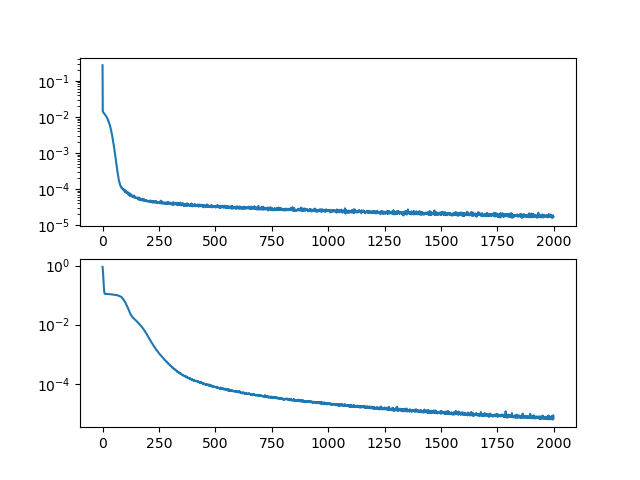

In [15]:
fig = plt.figure()
ax1, ax2 = fig.subplots(2, 1)
ax1.plot(hist_flower_init['loss'])
ax1.set_yscale('log')
ax2.plot(hist_vortex_init['loss'])
ax2.set_yscale('log')

In [16]:
from pinns.elm import elm

_x_bnd = array(Sobol(2, seed=123).random_base2(14))
_x_bnd = domain.transform_bnd(_x_bnd)


def phi2_solution(x, x_bnd, phi1, l, m):
    eps = 1e-10
    def g(y):
        n = unit_vec(-grad(l)(y))
        return dot(m(y), n) - dot(grad(phi1)(y), n)
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return 6 / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)


h_elm = lambda x: tanh(W_elm @ x + b_elm)
u_elm = lambda x: l(x) * h_elm(x)
Q_elm = vmap(lambda x: -laplace(u_elm)(x))(x_dom)
U_elm, S_elm, VT_elm = jax.scipy.linalg.svd(Q_elm, full_matrices=False, lapack_driver="gesvd")
H_bnd_elm = vmap(h_elm)(x_bnd)
U_bnd_elm, S_bnd_elm, VT_bnd_elm = jax.scipy.linalg.svd(H_bnd_elm, full_matrices=False, lapack_driver="gesvd")

def solve_stray_field(m):
    #u = lambda x: l(x) * h_elm(x)
    f = lambda x: -divergence(m)(x)
    #A = vmap(lambda x: -laplace(u)(x))(x_dom)
    b1 = vmap(f)(x_dom)
    #U, S, VT = jax.scipy.linalg.svd(A, full_matrices=False, lapack_driver="gesvd")
    params_phi1 = VT_elm.T @ ((1 / S_elm) * (U_elm.T @ b1))
    phi1 = lambda x: u_elm(x) @ params_phi1
    phi_bnd = phi2_solution(x_bnd, _x_bnd, phi1, l, m)
    #g2 = elm(h, x_bnd, phi_bnd, ridge=0.)
    params_phi_bnd = VT_bnd_elm.T @ ((1 / S_bnd_elm) * (U_bnd_elm.T @ phi_bnd))
    g2 = lambda x: h_elm(x) @ params_phi_bnd
    b2 = vmap(laplace(g2))(x_dom)
    params_phi2 = VT_elm.T @ ((1 / S_elm) * (U_elm.T @ b2))
    phi2 = lambda x: u_elm(x) @ params_phi2 + g2(x)
    phi_nn = lambda x: phi1(x) + phi2(x)
    return phi_nn


In [17]:
#phi = solve_stray_field(m_init_vortex)

In [18]:
# def ed(model, x):
#     Ms = 1.
#     H = lambda x: -grad(model)(x)
#     e = lambda x: dot(m_init_vortex(x), H(x)) 
#     return -Ms * (a * b * c) / 2 * jnp.sum(vmap(e)(x)) / len(x)

# abs(ed(phi, x_dom))

In [63]:
#Ms = 1.
#mu0 = 4 * pi * 1e-7
#Km = 1 / 2 * Ms ** 2
K1 = 0.1

def exchange_energy(m, x, lam):
    # lex = 1 / lam
    # A = lex ** 2 * Km
    A = 1 / (lam ** 2)
    def e_ex(x):
        
        dm = jacfwd(m)(x)
        #assert dm.shape == (3, 3)
        return jnp.sum(dm * dm)
        # _m = m(x)
        # lap_m = laplace(m)(x)
        # return -dot(_m, lap_m)
    return A * mean(vmap(e_ex)(x))

def ani_energy(m, x):
    def e_ani(x):
        c = array([0., 0., 1.])
        return 1 - (m(x) @ c) ** 2
        
    return K1 * mean(vmap(e_ani)(x))
    

def mag_energy(phi, m, x):
    def e_mag(x):
        h = lambda x: -grad(phi)(x)
        e = lambda x: dot(m(x), h(x)) 
        return e(x)
    
    return -mean(vmap(e_mag)(x))

def norm_con(m, x):
    def con(x):
        _m = m(x)
        return (norm(_m) - 1) ** 2
    return mean(vmap(con)(x))
     

def loss(params, x, lam):    
    _m = lambda x: unit_vec(mag_model.apply(lax.stop_gradient(params), concatenate((x, lam[None]))))
    m = lambda x: (mag_model.apply(params, concatenate((x, lam[None]))))
    phi = solve_stray_field(_m)
    
    e_ex = exchange_energy(m, x, lam)
    e_ani = ani_energy(m, x)
    e_mag = mag_energy(phi, m, x)
    con = norm_con(m, x)
    e = e_ex + e_ani + e_mag
    _l = e_ex + e_ani + 2 * e_mag + con
    return _l, {'loss': _l, 'energy': e, 
                'e_ex': e_ex, 'e_ani': e_ani, 
                'e_mag': e_mag, 'norm_con': con}

x_dom_train = x_dom  # concatenate([x_dom, x_bnd])
def train_mag(key, init_state, epochs=2000, batch_size=32):
    
    
    @jit
    def make_batches(rng):
        batches = x_dom_train.shape[0] // batch_size
        k1, k2 = random.split(rng)
        batch_size_dom = x_dom_train.shape[0] // batches

        perms_dom = jax.random.permutation(k1, x_dom_train.shape[0])
        perms_dom = perms_dom[:batches * batch_size_dom]  # skip incomplete batch
        perms_dom = perms_dom.reshape((batches, batch_size_dom))
        
        lam = draw_lam(k2, batches)
        
        return x_dom_train[perms_dom], lam
    
    # def make_schedule(batch_size, epochs):
    #     batches = x_dom.shape[0] // batch_size
    #     s_min = epochs * batches / 2
    #     s_max = s_min / 2
    #     init_lr = 1e-6
    #     max_lr = 0.5e-5
    #     min_lr = 1e-8
    #     v1 = (max_lr - init_lr) / s_max
    #     v2 = (min_lr - max_lr) / s_max
    #     def schedule(count):
    #         l1 = jnp.minimum(init_lr + v1 * count, max_lr)
    #         count2 = jnp.maximum(count - s_max, 0)
    #         l2 = jnp.maximum(max_lr + v2 * count2, min_lr)
    #         return lax.cond(
    #             count > s_max,
    #             lambda: l2, lambda: l1
    #         )
    #     return schedule
        
    # schedule = make_schedule(batch_size, epochs)
    batches = x_dom.shape[0] // batch_size
    schedule = optax.linear_schedule(1e-5, 1e-7, epochs * batches // 2)
    tx = optax.radam(schedule)
    
    init_state = TrainState.create(
        apply_fn=mag_model.apply, 
        params=init_state.params,
        tx=tx
    )
    return train_nn(loss, init_state, make_batches, train_key, epochs=epochs)



In [64]:
# key, train_key1, train_key2 = random.split(key, 3)
# flower_state, hist_flower1 = train_mag(train_key1, init_state_flower, epochs=1000, lr=1e-4)
# vortex_state, hist_vortex1 = train_mag(train_key2, init_state_vortex, epochs=1000, lr=1e-4)

In [65]:
key, train_key = random.split(key)
flower_state, hist_flower1 = train_mag(train_key, 
                                       init_state_flower, 
                                       epochs=150, 
                                       batch_size=100)


In [66]:
key, train_key = random.split(key)
vortex_state, hist_vortex1 = train_mag(train_key, 
                                       init_state_vortex, 
                                       epochs=150,
                                       batch_size=100)
# vortex_state, hist_vortex1 = train_mag(train_key2, init_state_vortex, epochs=8000, lr=1e-5)

In [67]:
# key, train_key1, train_key2 = random.split(key, 3)
# flower_state, hist_flower2 = train_mag(train_key1, flower_state, epochs=2000, lr=1e-7)

In [68]:
# vortex_state, hist_vortex2 = train_mag(train_key2, vortex_state, epochs=7000, lr=1e-5)

In [69]:

def total_energy(state, lam):
    lam = array(lam)
    m = lambda x: (mag_model.apply(state.params, concatenate((x, lam[None]))))
    phi = solve_stray_field(m)
    
    e_ex = exchange_energy(m, x_dom, lam)
    e_ani = ani_energy(m, x_dom)
    e_mag = mag_energy(phi, m, x_dom)
    
    e_tot = e_ex + e_ani + e_mag
    
    return {
        'e_tot': float(e_tot),
        'e_mag': float(e_mag),
        'e_ex': float(e_ex),
        'e_ani': float(e_ani),
    }

lam = 8.4375
#l_ex = array(10)
print(total_energy(flower_state, lam))
print(total_energy(vortex_state, lam))

{'e_tot': 0.22055712342262268, 'e_mag': 0.1635333001613617, 'e_ex': 0.013767422176897526, 'e_ani': 0.043256402015686035}
{'e_tot': 0.2134133130311966, 'e_mag': 0.023892641067504883, 'e_ex': 0.13306747376918793, 'e_ani': 0.056453194469213486}


In [70]:
@jit
def total_energy(state, lam):
    m = lambda x: (mag_model.apply(state.params, concatenate((x, lam[None]))))
    phi = solve_stray_field(m)
    
    e_ex = exchange_energy(m, x_dom, lam)
    e_ani = ani_energy(m, x_dom)
    e_mag = mag_energy(phi, m, x_dom)
    
    e_tot = e_ex + e_ani + e_mag
    
    return {
        'e_tot': e_tot,
        'e_mag': e_mag,
        'e_ex': e_ex,
        'e_ani': e_ani,
    }


def e(state, lam):
    return total_energy(state, lam)['e_tot']

lam = jnp.arange(8, 9, 0.05)
# energies_flower = vmap(e, (None, 0))(flower_state, lam)#[e(flower_state, l) for l in lam]
# energies_vortex = vmap(e, (None, 0))(vortex_state, lam)#[e(vortex_state, l) for l in lam]

energies_flower = lax.map(lambda l: e(flower_state, l), lam)
energies_vortex = lax.map(lambda l: e(vortex_state, l), lam)

/tmp/ipykernel_23653/2189533842.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Text(0, 0.5, 'E')

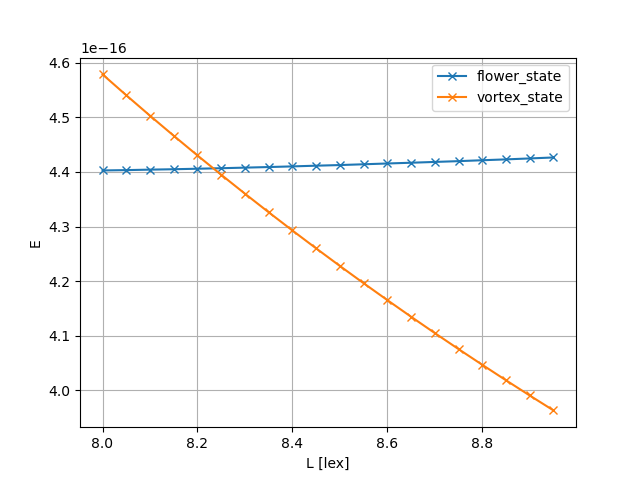

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lam, energies_flower * 2 * 10**(-15), "-x", label="flower_state")
ax.plot(lam, energies_vortex * 2 * 10**(-15), "-x", label="vortex_state")
ax.legend()
ax.grid()
ax.set_xlabel("L [lex]")
ax.set_ylabel("E")
#fig.savefig("crossing.png")

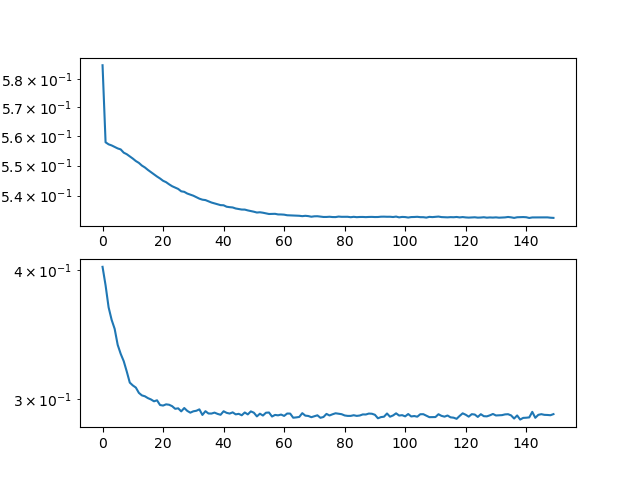

In [72]:
plot = 'loss'
fig = plt.figure()
ax1, ax2 = fig.subplots(2, 1)
ax1.plot(hist_flower1[plot])
ax1.set_yscale('log')
ax2.plot(hist_vortex1[plot])
ax2.set_yscale('log')

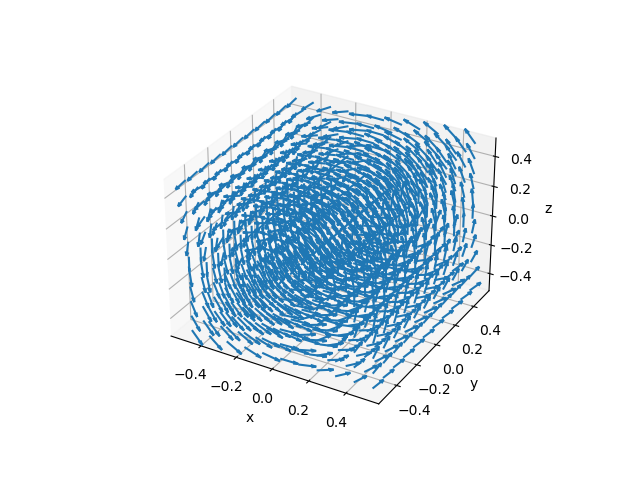

In [74]:
i = 0
# z2 = lambda x: sph2cat(mag_model.apply(state.params, x))[i]


ax = plt.figure().add_subplot(projection='3d')

# Make the grid
x, y, z = jnp.meshgrid(jnp.arange(-0.5, 0.51, 0.1),
                      jnp.arange(-0.5, 0.51, 0.1),
                      jnp.arange(-0.5, 0.51, 0.1))

X = jnp.stack([x, y, z], axis=-1)
_X = X.reshape(-1, 3)

def _mag(state, lex):
    lex = array(lex)
    _mag = vmap(
        lambda x: (mag_model.apply(state.params, concatenate((x, lex[None]))))
    )(_X).reshape(X.shape)
    return _mag

mag = _mag(vortex_state, 8.46)
# mag = vmap(
#     lambda x: sph2cat(mag_model.apply(vortex_state.params, concatenate((x, lex[None]))))
#     )(_X).reshape(X.shape)
#mag = sph2cat(mag_model.apply(state.params, _X)).reshape(X.shape)
#mag = sph2cat(mag_model.apply(init_state_flower.params, _X)).reshape(X.shape)
#mag = m_init_vortex(_X).reshape(X.shape)

ax.quiver(x, y, z, mag[..., 0], mag[..., 1], mag[..., 2], length=0.1, normalize=True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.gcf().savefig("mag.png")
# plt.show()

Text(0.5, 0, 'z')

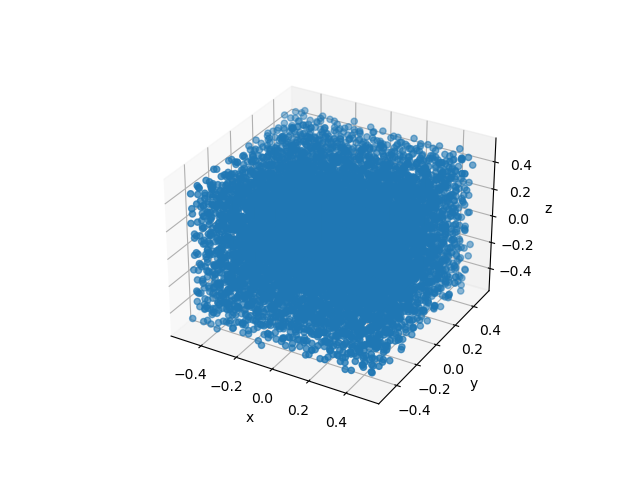

In [31]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(x_dom[..., 0], x_dom[..., 1], x_dom[..., 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

In [77]:
lam = array(8.46)
m = lambda x: unit_vec(mag_model.apply(flower_state.params, concatenate((x, lam[None]))))
# phi = solve_stray_field(m)
# stray_field = lambda x: -grad(phi)(x)


In [78]:
mean(vmap(m)(x_dom), axis=0)

DeviceArray([1.0097211e-04, 4.2214445e-03, 9.6698040e-01], dtype=float32)

Text(0.5, 0, 'z')

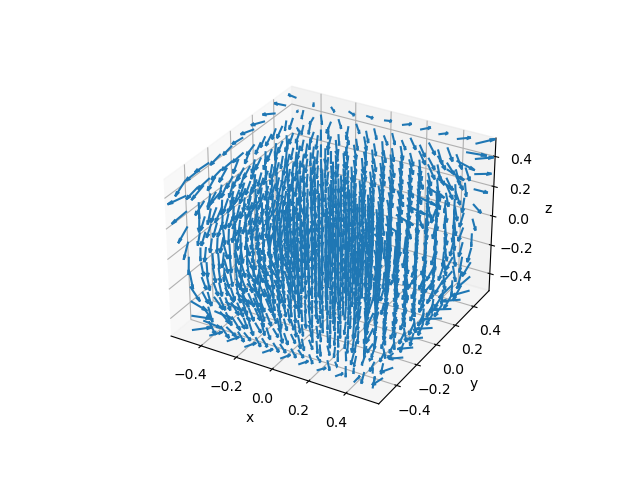

In [34]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
x, y, z = jnp.meshgrid(jnp.arange(-0.5, 0.51, 0.1),
                      jnp.arange(-0.5, 0.51, 0.1),
                      jnp.arange(-0.5, 0.51, 0.1))

X = jnp.stack([x, y, z], axis=-1)
_X = X.reshape(-1, 3)

h = vmap(stray_field)(_X).reshape(X.shape)
# mag = vmap(
#     lambda x: sph2cat(mag_model.apply(vortex_state.params, concatenate((x, lex[None]))))
#     )(_X).reshape(X.shape)
#mag = sph2cat(mag_model.apply(state.params, _X)).reshape(X.shape)
#mag = sph2cat(mag_model.apply(init_state_flower.params, _X)).reshape(X.shape)
#mag = m_init_vortex(_X).reshape(X.shape)

ax.quiver(x, y, z, h[..., 0], h[..., 1], h[..., 2], length=0.1, normalize=True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

In [35]:
def _mag(state, lex):
    lex = array(lex)
    _mag = vmap(
        lambda x: sph2cat(mag_model.apply(state.params, concatenate((x, lex[None]))))
    )(x_dom)
    return _mag
mag = _mag(init_state_flower, 8.46)


In [36]:
mean(mag, axis=0)

DeviceArray([ 9.3859009e-04, -2.7357385e-04,  9.9334198e-01], dtype=float32)